#Imports

In [1]:
# !pip install amazon-braket-sdk

In [2]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import time
from braket.aws import AwsDevice
from braket.circuits import Circuit
from braket.circuits.circuit import subroutine
from braket.devices import LocalSimulator
from braket.parametric import FreeParameter
from scipy.optimize import minimize
import pickle
from datetime import datetime
import pylab as pl
from matplotlib import collections  as mc
from braket.tracking import Tracker

#Problem digitalization (e.g input data for RCPSP)

In [3]:
# activies numeration should start from 1

real_num_activities = 3
T = 4
precedence_graph_edges = np.array([[2, 3], [1, 3]])
activity_processing_time = np.array([1, 1, 2])
resourse_capacity = np.array([3, 3, 4])
resourse_consumption = np.array([[1, 2, 1], [0, 3, 1], [1, 1, 3]])
number_of_recourses = resourse_capacity.shape[0]

# real_num_activities = 3
# T = 5
# precedence_graph_edges = np.array([[2, 3], [1, 3]])
# activity_processing_time = np.array([1, 2, 2])
# resourse_capacity = np.array([3, 3, 4])
# resourse_consumption = np.array([[1, 2, 1], [0, 1, 1], [1, 1, 3]])
# number_of_recourses = resourse_capacity.shape[0]

Add dummy activities

In [4]:
def add_smart_dummy_activities_no_start(real_num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption):
    num_activities = real_num_activities
    starting_activity = None
    end_activity = None

    has_outcoming = [False] * (real_num_activities+1)
    has_incoming = [False] * (real_num_activities+1)
    for edge in precedence_graph_edges:
        has_outcoming[int(edge[0])] = True
        has_incoming[int(edge[1])] = True
    # mark 0 index True, so it won't be counted
    has_incoming[0] = True
    has_outcoming[0] = True
    to_insert_start_activity = has_incoming.count(False) > 1
    to_insert_end_activity = has_outcoming.count(False) > 1
    for i in range(1, real_num_activities+1):
        if to_insert_end_activity and not has_outcoming[i]:
            precedence_graph_edges = np.concatenate([precedence_graph_edges, [[i, real_num_activities+1]]])
        if not to_insert_start_activity and not has_incoming[i]:
            starting_activity = i
        if not to_insert_end_activity and not has_outcoming[i]:
            end_activity = i

    if to_insert_end_activity:
        print("inserted end activity")
        num_activities += 1
        activity_processing_time = np.concatenate([activity_processing_time, [0]])
        resourse_consumption = np.concatenate([resourse_consumption, [[0] * number_of_recourses]])
        end_activity = real_num_activities+1

    # shift numeration to be from zero
    if not starting_activity is None:
        starting_activity -= 1
    end_activity -= 1
    for edge in precedence_graph_edges:
        edge[0] -= 1
        edge[1] -= 1

    return num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption, starting_activity, end_activity

In [5]:
num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption, starting_activity, end_activity = add_smart_dummy_activities_no_start(real_num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption)

#Calculating time windows

In [6]:
def longest_paths_in_postive_graph(G, weigth_func):
    # find shortest path for -G, O(V+E)
    topological_order = list(nx.topological_sort(G)) # Kahn's algorithm (incoming degrees), O(V+E)
    # all incoming weights are non-negative, because of reverse sign of weights, zero weight path is max
    shortest_path = np.full_like(activity_processing_time, 0)
    for node in topological_order:
        for neighbor in G[node]:
            if not neighbor is None and shortest_path[neighbor] > shortest_path[node] - weigth_func(node, neighbor):
                shortest_path[neighbor] = shortest_path[node] - weigth_func(node, neighbor)
    return -shortest_path

In [7]:
def calculate_time_windows(precedence_graph_edges, end_activity):
    # calculate earliest start
    # by finding longest paths from source (start activity) to every node, weights - activity processing time
    precedence_graph_edges_with_start_activity = np.copy(precedence_graph_edges)
    if starting_activity is None:
        precedence_graph_edges_with_start_activity = np.concatenate([[np.array([-1, i]) for i in range(0, num_activities)], precedence_graph_edges_with_start_activity])
    G = nx.from_edgelist(precedence_graph_edges_with_start_activity, create_using=nx.DiGraph)
    earliest_start = longest_paths_in_postive_graph(G, lambda u, v: activity_processing_time[u] if u > -1 else 0)
    # calculate latest start
    latest_start = np.full_like(activity_processing_time, 0)
    for activity in range(0, num_activities):
        descendants = []
        if G.has_node(activity):
            descendants = nx.descendants(G, activity)
        for activity2 in range(0, num_activities):
            if not (activity2 in descendants):
                latest_start[activity] += activity_processing_time[activity2]
        latest_start[activity] = min(T, latest_start[activity])

    return earliest_start, latest_start

In [8]:
earliest_start, latest_start = calculate_time_windows(precedence_graph_edges, end_activity)
T = latest_start[end_activity]

# QUBO variables, objective and penalties

## Variables

In [9]:
number_of_activities_variables = 0
for i in range(0, num_activities):
    number_of_activities_variables += latest_start[i] - earliest_start[i] + 1

In [10]:
number_of_variables = number_of_activities_variables

In [11]:
number_of_variables

10

In [12]:
activity_time_index_start = np.empty_like(activity_processing_time)
cur_index = 0
for i in range(0, num_activities):
    activity_time_index_start[i] = cur_index
    cur_index += latest_start[i] - earliest_start[i] + 1

In [13]:
def activity_time_to_index(activity_index, time_index):
    assert(time_index >= earliest_start[activity_index] and time_index <= latest_start[activity_index])
    return activity_time_index_start[activity_index] + time_index - earliest_start[activity_index]

In [14]:
def from_index_to_activity_time(index):
    for i in range(0, num_activities):
        if index >= activity_time_index_start[i] and index <= activity_time_index_start[i] + latest_start[i] - earliest_start[i]:
            return i, earliest_start[i] + index - activity_time_index_start[i]

## Objective function

In [15]:
def add_objective_function(Q, last_activity):
    for t in range(earliest_start[last_activity], latest_start[last_activity]+1):
        i = activity_time_to_index(num_activities - 1, t)
        Q[i, i] += t

## Each activity starts 1 time constraint

In [16]:
def add_activity_one_start_penalty(Q, offset, penalty_coef):
    for activity in range(0, num_activities):
        for t1 in range(earliest_start[activity], latest_start[activity]+1):
            for t2 in range(earliest_start[activity], latest_start[activity]+1):
                i = activity_time_to_index(activity, t1)
                j = activity_time_to_index(activity, t2)
                if i > j:
                    i, j = j, i
                Q[i, j] += penalty_coef
            i = activity_time_to_index(activity, t1)
            Q[i, i] -= 2*penalty_coef
    offset += num_activities * penalty_coef
    return offset

## Precedence constraint

In [17]:
def add_precedence_penalty(Q, penalty_coef):
    for edge in precedence_graph_edges:
        from_activity = edge[0]
        to_activity = edge[1]
        for t1 in range(earliest_start[from_activity], latest_start[from_activity]+1):
            for t2 in range(earliest_start[to_activity], min(t1 + activity_processing_time[from_activity], latest_start[to_activity]+1)):
                i = activity_time_to_index(from_activity, t1)
                j = activity_time_to_index(to_activity, t2)
                if i > j:
                    i, j = j, i
                Q[i, j] += penalty_coef

## Unbalanced Resource constraints

In [18]:
def add_unbalanced_resourse_penalty(Q, offset, penalty_coef1, penalty_coef2):
    for t in range(0, latest_start[end_activity]+1):
        for k in range(0, number_of_recourses):
            for i1 in range(0, num_activities):
                for i2 in range(0, num_activities):
                    for r1 in range(max(t - activity_processing_time[i1] + 1, earliest_start[i1]), min(t, latest_start[i1])+1):
                        for r2 in range(max(t - activity_processing_time[i2] + 1, earliest_start[i2]), min(t, latest_start[i2])+1):
                            i = activity_time_to_index(i1, r1)
                            j = activity_time_to_index(i2, r2)
                            if i > j:
                                i, j = j, i
                            Q[i, j] += penalty_coef2 * resourse_consumption[i1, k] * resourse_consumption[i2, k]
            for i1 in range(0, num_activities):
                for r in range(max(t - activity_processing_time[i1] + 1, earliest_start[i1]), min(t, latest_start[i1])+1):
                    i = activity_time_to_index(i1, r)
                    Q[i, i] += (penalty_coef1 - 2 * resourse_capacity[k]  * penalty_coef2) * resourse_consumption[i1, k]
            offset += penalty_coef2 * resourse_capacity[k] ** 2 - penalty_coef1 * resourse_capacity[k]
    return offset

# QUBO formation

In [19]:
def form_RCPSP_QUBO(resourse_penalty1, resourse_penalty2):
    Q = np.zeros((number_of_variables, number_of_variables))
    qubo_offset = 0.0
    add_objective_function(Q, end_activity)
    qubo_offset = add_unbalanced_resourse_penalty(Q, qubo_offset, resourse_penalty1, resourse_penalty2)
    one_start_penalty = abs(max(Q.min(), Q.max(), key=abs)) * 2
    precedence_penalty = one_start_penalty
    qubo_offset = add_activity_one_start_penalty(Q, qubo_offset, one_start_penalty)
    add_precedence_penalty(Q, precedence_penalty)
    return Q, qubo_offset, one_start_penalty, precedence_penalty

In [20]:
resourse_penalty1, resourse_penalty2 = 0.11, 0.0833 # for more than 4 activities
if real_num_activities < 5:
    resourse_penalty1, resourse_penalty2 = 0.53, 0.125

In [21]:
Q, qubo_offset, one_start_penalty, precedence_penalty = form_RCPSP_QUBO(resourse_penalty1, resourse_penalty2)

# To Ising

In [22]:
def from_Q_to_Ising(Q, offset):
    ising_offset = np.copy(offset)
    n_var = len(Q)  # Get the number of variables in the QUBO matrix

    h = np.zeros((n_var))
    J = np.zeros((n_var, n_var))

    # Loop over each variable in the QUBO matrix
    for i in range(n_var):
        # Update the magnetic field for qubit i based on its diagonal element in Q
        h[i] -= Q[i, i] / 2
        # Update the offset based on the diagonal element in Q
        ising_offset += Q[i, i] / 2
        # Loop over other variables to calculate pairwise interactions
        for j in range(i + 1, n_var):
            # Update the pairwise interaction strength (J) between variables i and j
            J[i, j] += Q[i, j] / 4
            # Update the magnetic fields for variables i and j based on their interactions in Q
            h[i] -= Q[i, j] / 4
            h[j] -= Q[i, j] / 4
            # Update the offset based on the interaction strength between variables i and j
            ising_offset += Q[i, j] / 4
    # Return the magnetic fields, pairwise interactions, and the updated offset
    return h, J, ising_offset

In [23]:
h, J, ising_offset = from_Q_to_Ising(Q, qubo_offset)

# QAOA

In [24]:
cost_tracker = Tracker().start()

## Helpers

In [25]:
def is_np_array_in_list(val, array_list):
    for array in array_list:
        if np.allclose(array, val):
            return True
    return False

In [26]:
# the testing ones
if real_num_activities == 3 and T == 4:
    known_optimal_solutions = [-2*np.array([0, 1, 0, 1, 0, 0, 0, 1, 0, 0])+1, -2*np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0])+1]
if real_num_activities == 3 and T == 5:
    known_optimal_solutions = [-2*np.array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])+1,
 np.array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])+1]

In [27]:
def save_tracker_to_file(tracker, name):
    # store results: dump output to pickle with timestamp in filename
    time_now = datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
    results_file = name + '-'+time_now+'.pkl'
    print(f'Writing results to file: {results_file}')
    pickle.dump(tracker, open(results_file, "wb"))

## Circuit

In [28]:
@subroutine(register=True)
def mixer_layer(beta, n_qubits):
    """
    Returns circuit for mixer Hamiltonian U(Hb, beta)
    """
    # instantiate circuit object
    circ = Circuit()

    # apply parametrized rotation around x to every qubit
    for qubit in range(n_qubits):
        gate = Circuit().rx(qubit, 2 * beta)
        circ.add(gate)

    return circ


@subroutine(register=True)
def cost_layer(gamma, n_qubits, h_ising, J_ising):
    """
    returns circuit for evolution with cost Hamiltonian
    """
    # instantiate circuit object
    circ = Circuit()

    for qubit in range(h_ising.shape[0]):  # single-qubit terms
        if abs(h_ising[qubit]) > 1e-3:
            gate = Circuit().rz(qubit, 2 * gamma * h_ising[qubit])
            circ.add(gate)

    # two-qubit terms
    for qubit1 in range(0, J_ising.shape[0]):
        for qubit2 in range(qubit1 + 1, J_ising.shape[1]):
            if abs(J_ising[qubit1, qubit2]) > 1e-3:
                gate = Circuit().zz(qubit1, qubit2, angle=2 * gamma * J_ising[qubit1, qubit2])
                circ.add(gate)

    return circ

@subroutine(register=True)
def qaoa_circuit(params, device, n_qubits, h_ising, J_ising):
    """
    function to return full QAOA circuit
    """

    circ = Circuit()

    H_on_all = Circuit().h(range(0, n_qubits))
    circ.add(H_on_all)

    # setup two parameter families
    circuit_length = int(len(params) / 2)
    gammas = params[:circuit_length]
    betas = params[circuit_length:]

    # add QAOA circuit layer blocks
    for mm in range(circuit_length):
        circ.cost_layer(gammas[mm], n_qubits, h_ising, J_ising)
        circ.mixer_layer(betas[mm], n_qubits)

    return circ

## Cost function

In [29]:
# function that computes cost function for given params
def cost_function(params, qaoa_circuit, h_ising, J_ising, device, n_shots, tracker, verbose):
    """
    cost function takes a list of variational parameters as input,
    and returns the cost associated with those parameters
    """

    if verbose:
        print("==================================" * 2)
        print("Calling the quantum circuit. Cycle:", tracker["count"])

    # create parameter dict
    params_dict = {str(fp): p for fp, p in zip(qaoa_circuit.parameters, params)}

    # execute
    task = device.run(qaoa_circuit, shots=n_shots, inputs=params_dict)
    result = task.result()
    meas_ising = -2*result.measurements + 1
    all_energies = np.diag(meas_ising @ J_ising @ meas_ising.T) + meas_ising @ h_ising
    # find minimum and corresponding classical string
    energy_min = np.min(all_energies)
    optimal_string = meas_ising[np.argmin(all_energies)]
    energy_expect = np.sum(all_energies) / n_shots


    tracker["opt_energies"].append(energy_min)
    tracker["opt_ising_bitstrings"].append(optimal_string)


    # store global minimum
    tracker["global_energies"].append(tracker["optimal_energy"])

    braket_tasks_cost = cost_tracker.qpu_tasks_cost() + cost_tracker.simulator_tasks_cost()

    if verbose:
        print("Minimal energy:", energy_min)
        print("Optimal classical string:", optimal_string)
        print("Energy expectation value (cost):", energy_expect)
        print("Parameters:", params)
        print("Cost so far (USD dollars):", braket_tasks_cost)

    # update tracker
    braket_tasks_cost = cost_tracker.qpu_tasks_cost() + cost_tracker.simulator_tasks_cost()
    tracker.update({"count": tracker["count"] + 1, "res": result.measurements, 'job_cost': braket_tasks_cost})
    tracker["costs"].append(energy_expect)
    tracker["params"].append(params)

    if tracker['min_energy_expect'] is None or energy_expect < tracker['min_energy_expect']:
        tracker.update({"min_energy_expect": energy_expect})
        tracker.update({"opt_params": params})

    # store optimal (classical) result/bitstring
    if energy_min < tracker["optimal_energy"] or np.allclose(energy_min, tracker["optimal_energy"]):
        tracker.update({"optimal_energy": energy_min})
        tracker.update({"optimal_bitstring": ((-optimal_string+1)/2)})
        if is_np_array_in_list(optimal_string, known_optimal_solutions):
            end = time.time()
            tracker.update({"time": end - tracker["time"]})
            print("Found optimal!")
            raise RuntimeError("Found optimal solution")

    save_tracker_to_file(tracker, 'checkpoint' + str(tracker["count"]))

    return energy_expect

## Optimization (or training)

In [30]:
# The function to execute the training: run classical minimization.
def train(
    device, options, p, h_ising, J_ising, n_qubits, n_shots, opt_method, tracker, gamma_initial, beta_initial, verbose=True
):
    """
    function to run QAOA algorithm for given, fixed circuit depth p
    """
    print("Starting the training.")

    print("==================================" * 2)
    print(f"OPTIMIZATION for circuit depth p={p}")

    if not verbose:
        print('Param "verbose" set to False. Will not print intermediate steps.')
        print("==================================" * 2)

    params0 = np.array(gamma_initial + beta_initial)

    # set bounds for search space
    bnds_gamma = [(0, 2 * np.pi) for _ in range(int(len(params0) / 2))]
    bnds_beta = [(0, np.pi) for _ in range(int(len(params0) / 2))]
    bnds = bnds_gamma + bnds_beta

    gamma_params = [FreeParameter(f"gamma_{i}") for i in range(p)]
    beta_params = [FreeParameter(f"beta_{i}") for i in range(p)]
    params = gamma_params + beta_params
    qaoa_circ = qaoa_circuit(params, device, n_qubits, h_ising, J_ising)
    # run classical optimization
    result = minimize(
        cost_function,
        params0,
        args=(qaoa_circ, h_ising, J_ising, device, n_shots, tracker, verbose),
        options=options,
        method=opt_method,
        bounds=bnds
    )

    # store result of classical optimization
    result_energy = result.fun
    result_angle = result.x

    return result_energy, result_angle, tracker

## Classical optimization

In [63]:
#device = LocalSimulator()
# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/ionq/Aria-1")

In [70]:
device.queue_depth()

QueueDepthInfo(quantum_tasks={<QueueType.NORMAL: 'Normal'>: '0', <QueueType.PRIORITY: 'Priority'>: '0'}, jobs='0')

In [71]:
# set up hyperparameters

DEPTH = 1  # circuit depth for QAOA
SHOTS = 100 # 100 # number measurements to make on circuit
OPT_METHOD = 'Nelder-Mead'

# set up the problem
n_qubits = number_of_variables

# initialize reference solution (simple guess)
bitstring_init = -1 * np.ones([n_qubits])
energy_init = bitstring_init @ J @ bitstring_init + h @ bitstring_init
print("energy_init", energy_init)

max_func_eval = 50

energy_init 143.1975


In [72]:
# set options for classical optimization
options = {'disp': True, 'maxfev': max_func_eval}
# set tracker to keep track of results
tracker = {
    'count': 0,                           # Elapsed optimization steps
    'optimal_energy': energy_init,        # Global optimal energy
    'opt_energies': [],                   # Optimal energy at each step
    'global_energies': [],                # Global optimal energy at each step
    'optimal_bitstring': bitstring_init,  # Global optimal bitstring
    'opt_ising_bitstrings': [],           # Optimal bitstring at each step
    'costs': [],                          # Cost (average energy) at each step
    'res': None,                          # Quantum result object
    'params': [],                         # Track parameters
    'opt_params': None,                   # Track optimal parameters
    'min_energy_expect': None,            # Global minumum energy expectation value reached
    'job_cost': None,                     # Cost in USD of AWS Braket services
    'time': None,                         # Time of the optimization
    'msg': None                           # message about the result: "Found optimal solution", "Maximum number of function evaluations reached", f"{Error_message}"
}

# reprodusability and initial parameters
if real_num_activities == 3 and T == 4:
    np.random.seed(4)
if real_num_activities == 3 and T == 5:
    np.random.seed(8)

# run QAOA optimization


gamma_initial = np.random.uniform(0, 2 * np.pi, DEPTH).tolist()
beta_initial = np.random.uniform(0, np.pi, DEPTH).tolist()
# start optimization
start_time = time.time()
tracker.update({"time": start_time})
try:
    result_energy, result_angle, tracker = train(
        device = device, options=options, p=DEPTH, h_ising=h, J_ising = J, n_qubits=n_qubits, n_shots=SHOTS,
        opt_method=OPT_METHOD, tracker=tracker, gamma_initial = gamma_initial,
            beta_initial = beta_initial, verbose=True)
    tracker.update({"msg": "Maximum number of function evaluations exceeded"})
except Exception as e:
    tracker.update({"msg": str(e)})
finally:
    save_tracker_to_file(tracker, 'results')
    end = time.time()
    tracker.update({"time": end - tracker["time"]})
    print("Results:")
    print(tracker)

Starting the training.
OPTIMIZATION for circuit depth p=1
Calling the quantum circuit. Cycle: 0
Minimal energy: -44.8075
Optimal classical string: [-1  1  1 -1  1  1  1 -1  1  1]
Energy expectation value (cost): 4.112600000000001
Parameters: [6.07602768 1.71918081]
Cost so far (USD dollars): 10.6275000000
Writing results to file: checkpoint1-20240528210239.pkl
Calling the quantum circuit. Cycle: 1
Minimal energy: -46.557500000000005
Optimal classical string: [-1  1  1  1 -1  1  1 -1  1  1]
Energy expectation value (cost): -1.30655
Parameters: [6.18654155 1.71918081]
Cost so far (USD dollars): 13.9275000000
Found optimal!
Writing results to file: results-20240528213605.pkl
Results:
{'count': 2, 'optimal_energy': -46.557500000000005, 'opt_energies': [-44.8075, -46.557500000000005], 'global_energies': [143.1975, -44.8075], 'optimal_bitstring': array([1., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), 'opt_ising_bitstrings': [array([-1,  1,  1, -1,  1,  1,  1, -1,  1,  1]), array([-1,  1,  1,  1, -

# Visualization

In [67]:
def visualize_solution(x, offset_activity_num=0):
    fig, ax = pl.subplots()
    lines = []
    for i in range(0, x.shape[0]):
        if x[i] == 1:
            activity, time = from_index_to_activity_time(i)
            print(i, activity, time)
            if activity_processing_time[activity] > 0:
                lines.append([(time, activity), (time + activity_processing_time[activity], activity)])
                ax.text(time + activity_processing_time[activity] / 2, activity + 0.1, f'{activity + offset_activity_num}')

    lc = mc.LineCollection(lines, linewidths=2)
    ax.add_collection(lc)
    ax.set_xlabel('час', fontsize=18)
    ax.set_ylabel('дія', fontsize=18)
    ax.autoscale()
    ax.margins(0.1)

0 0 0
4 1 1
7 2 2


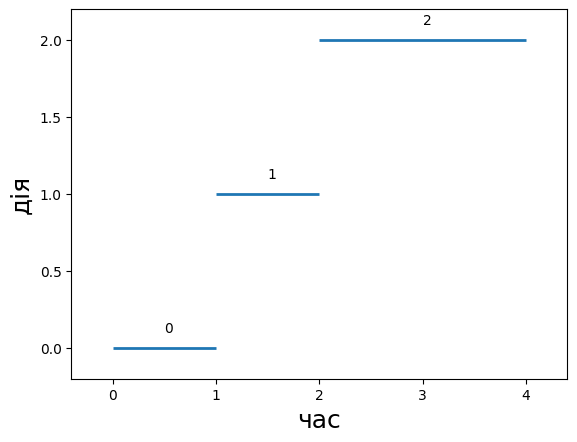

In [73]:
visualize_solution(tracker['optimal_bitstring'])

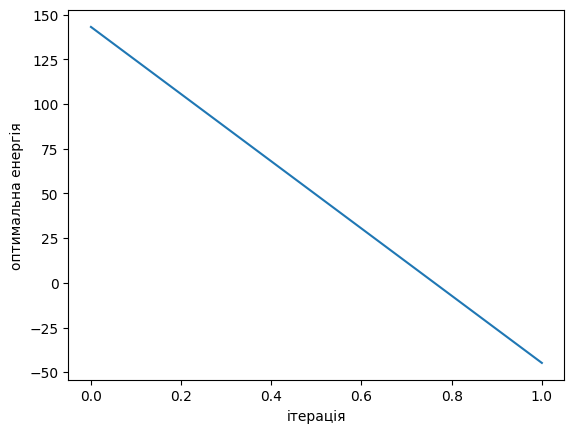

In [74]:
plt.plot(tracker["global_energies"])
plt.ylabel('оптимальна енергія')
plt.xlabel('ітерація')
plt.show()

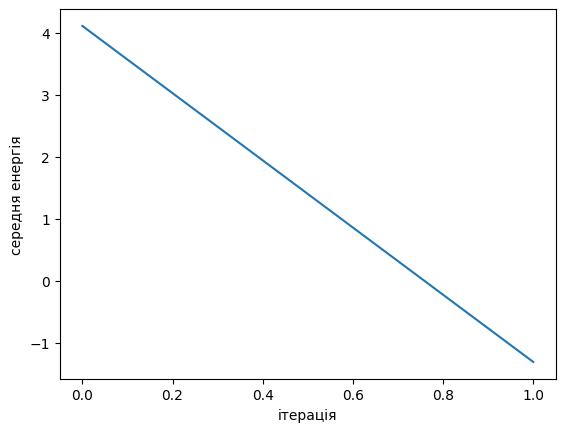

In [75]:
plt.plot(tracker["costs"])
plt.ylabel('середня енергія')
plt.xlabel('ітерація')
plt.show()